#Artificial Intelligence - COMP9414
###Tutorial week 4 - Reinforcement learning

On-policy SARSA in a gridworld

@Author: __Francisco Cruz__


##Theoretical Background

Reinforcement learning (RL) is a machine learning method based on behavioural psychology. It allows an agent to learn how to perform new tasks by exploring the environment and observing state modifications and possible rewards. The method is oriented toward goals in which an agent, either human or robotic, tries to maximise the long-term cumulative reward by iterative interactions with the environment.

An RL problem is comprised of:

* A policy: that defines how an agent selects an action aiming to maximize the reward signal obtained.
* A reward signal: that establishes a definition of positive and/or negative * events, i.e., the aims to be achieved by the RL agent.
* A value function: that specifies how good the reward signal might be over time from one state or a state-action pair.
* Optionally, a model of the environment: that allows the agent to infer what will be the next state and reward, given any state and action.

Based on this model, an RL agent is able to learn the optimal policy that allows selecting the action leading to the highest cumulative reward given the value function.

Markov decision processes (MDPs) are the base of RL tasks.
In an MDP, transitions and rewards depend only on the current state and the selected action by the agent.
In other words, a Markov state contains all the information related to the dynamics of a task, i.e., once the current state is known, the history of transitions that led the agent to that position is irrelevant in terms of the decision-making problem.

An MDP is characterized by the 4-tuple $<S, A, \delta, r>$ where:

* $S$ is a finite set of states,
* $A$ is a set of actions,
* $\delta$ is the transition function $\delta:S \times A \rightarrow S$, and,
* $r$ is the reward function $r:S \times A \rightarrow \mathbb{R}$.

At each time $t$, the agent perceives the current state $s_t \in S$ and selects the action $a_t \in A$ to perform it.
The environment returns the reward $r_t= r(s_t, a_t)$ and the agent transits to the state $s_{t+1}= \delta(s_t, a_t)$.
The functions $r$ and $\delta$ depend only on the current state and action, i.e., it is a process with no memory.

Actions are selected according to a policy $\pi$, which in psychology is called a set of stimulus-response rules or associations.
Thus, the value of taking an action $a$ in a state $s$ under a policy $\pi$ is denoted $q^{\pi}(s,a)$ which is also called the action-value function for a policy $\pi$.

To find a policy, diverse learning methods exist, e.g., SARSA and Q-learning.
The on-policy method SARSA considers transitions from state-action pair to state-action pair.
In the Q-learning method, state-action values are updated using the best possible action from the next state.

* SARSA equation:
\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t)+\alpha[r_{t+1}+\gamma Q(s_{t+1},a_{t+1})- Q(s_t,a_t)]
\end{equation}

* Q-learning equation:
\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t)+\alpha[r_{t+1}+\gamma\max_{a \in A(s_{t+1})} Q(s_{t+1},a)- Q(s_t,a_t)]
\end{equation}



__Section 2. Setup__


1. Using Python, create a gridworld of variable dimension $n \times m$ allowing positive and negative rewards for some positions.

2. Create methods for returning the current state, the reward, the number of states, and the number of actions.

3. Create a method to perform an action into the gridworld, i.e., a method that move the agent from one state to another given one of the following actions: right, left, up, down.

4. Consider only valid movements, i.e., actions attempting to move the agent out of the gridworld have no effect.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class World(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.R = np.zeros(self.x*self.y)
        self.agentPos = 0

    def idx2xy(self,idx):
        x = int(idx / self.y)
        y = idx % self.y
        return x, y

    def xy2idx(self,x,y):
        return x*self.y + y

    def resetAgent(self, pos):
        self.agentPos = int(pos)

    def setReward(self, x, y, r):
        goalState = self.xy2idx(x, y)
        self.R[goalState] = r

    def getState(self):
        return self.agentPos

    def getReward(self):
        if self.agentPos == -1:
            return -1.0
        else:
            return self.R[self.agentPos]

    def getNumOfStates(self):
        return self.x*self.y

    def getNumOfActions(self):
        return 4

    def move(self,id):
        x_, y_ = self.idx2xy(self.agentPos)
        tmpX = x_
        tmpY = y_
        if id == 0: # move DOWN
            tmpX += 1
        elif id == 1: # move UP
            tmpX -= 1
        elif id == 2: # move RIGHT
            tmpY += 1
        elif id == 3: # move LEFT
            tmpY -= 1
        else:
            print("ERROR: Unknown action")

        if self.validMove(tmpX, tmpY):
            self.agentPos = self.xy2idx(tmpX,tmpY)

    def validMove(self,x,y):
        valid = True
        if x < 0 or x >= self.x:
            valid = False
        if y < 0 or y >= self.y:
            valid = False
        return valid


__Section 2. Setup.__

5. Create a reinforcement learning agent with the following characteristics:
  * Use a Q-table with Q-values randomly initialized. Use a uniform distribution between $0$ and $0.1$.
  * Learning parameters: learning rate $\alpha=0.7$, discount factor $\gamma=0.4$, and $\epsilon$-greedy action selection method with $\epsilon=0.25$.
  * Implement the temporal-different on-policy method SARSA for training.


In [ ]:
class Agent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.random.uniform(0.0,0.01,(self.numOfStates,self.numOfActions))
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    # epsilon-greedy action selection
    def actionSelection(self, state):
        if (np.random.rand() <= self.epsilon):
            action = np.random.randint(self.numOfActions)
        else:
            action = np.argmax(self.Q[state,:])

        return action

    def train(self, iter):
        for itr in range(iter):

            state = int(np.random.randint(0,self.numOfStates))
            self.world.resetAgent(state)

            # choose action
            a = self.actionSelection(state)
            expisode = True

            while expisode:
                # perform action
                self.world.move(a)
                # look for reward
                reward = self.world.getReward()
                state_new = int(self.world.getState())

                # new action
                a_new = self.actionSelection(state_new)

                # update Q-values
                self.Q[state,a] += self.alpha*(reward +
                                    self.gamma*self.Q[state_new,a_new]-
                                    self.Q[state,a])

                state = state_new
                a = a_new

                if reward == 1.0:
                    self.Q[state_new,:] = 0
                    expisode = False

        print(self.Q)

    def plotQValues(self):
        plt.rcParams.update({'font.size': 18})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()


__Section 3. Experiments__

1. Create a $3 \times 4$ gridworld.

2. Use the grid $(2,3)$ as the goal position with reward $1.0$ and the grid $(1,1)$ as a fear regioon with reward $-1.0$.

3. Create a learner agent to navigate the gridworld previously created.

4. Train the reinforcemente learning agent using SARSA for $1000$ episodes.

5. Plot the Q-values. Observe the state-action pair moving the agent to both the goal and fear positions.


[[-0.08130751 -0.03519311 -0.01434241 -0.02136956]
 [-0.94055039 -0.01260737  0.05390196 -0.00786583]
 [ 0.09381017  0.04438879  0.15992659  0.00645357]
 [ 0.39999308  0.02697205  0.03634673  0.05348774]
 [-0.07580513 -0.02678203 -0.94098994 -0.27657011]
 [ 0.15701936  0.0067517  -0.21915989  0.00212018]
 [ 0.09846334  0.0479676   0.14255547 -0.94179474]
 [ 1.          0.03245078  0.13301597  0.0355441 ]
 [ 0.04916836 -0.10130217  0.07988172  0.04060015]
 [ 0.14816343 -0.98483955  0.32887129  0.00696938]
 [ 0.31653707  0.15860911  1.          0.06838195]
 [ 0.          0.          0.          0.        ]]


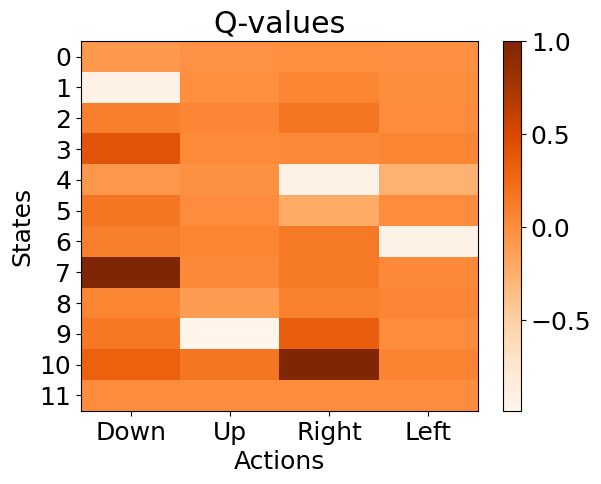

In [ ]:
#Section 3.a.
world = World(3,4)

#Section 3.b.
world.setReward(2, 3, 1.0) #Goal state
world.setReward(1, 1, -1.0) #Fear region

#Section 3.c.
learner = Agent(world)

#Section 3.d.
learner.train(1000)

#Section 3.e.
learner.plotQValues()